<a href="https://colab.research.google.com/github/saso-gatto/Yashi-Game/blob/main/KN_YashiGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Yashi Game**

Project for "Knowledge Representation and Learning" course at University of Padua.

Salvatore Gatto, 2044587


**The Game**

An instance of the Yashi game is specifid by a n × n integer grid for some n > 2, on which p > 2 nodes are placed. A solution of the game consists in drawing horizontal and vertical segments, satisfying the following conditions:
1. No two segments cross each other.
2. The segments form a tree, i.e., they form a graph without cycles. Put differently
still, for every two nodes a and b there is exactly one path between a and b

**Rules in details**

In Yashi Games, you can connect any two dots by using a single horizontal or single vertical line. You cannot use any diagonal lines or curved lines, and you cannot connect two dots with a path that has angles or corners. No L-shapes, no Z-shapes, just single straight lines. Each dot may be connected to 1, 2, 3 or 4 other dots, either horizontally, vertically or both. Your lines cannot cross each other, and they cannot pass through other dots, or go on top of other lines.

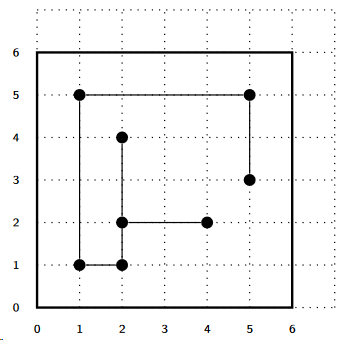


**SAT PROJECT**

Given an instance G of Yashi, develop a SAT based method to answer the following questions:
1. Decide if there is a solution for G. If there is, return one solution.
2. Decide if there is a solution for G. If there is, return a minimum-length solution.

Idea: riprodurre un sistema di assi cartesiani X,Y.

In [1]:
!pip install python-sat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.5 MB/s eta 0:00:00


In [2]:
from pysat.formula import WCNF,CNF
from pysat.solvers import Minisat22
from pysat.examples.fm import FM

from itertools import chain
from collections import defaultdict, deque
from io import StringIO
from typing import List, Set, Dict, NewType, Tuple
import random
import math
import matplotlib.pyplot as plt

In [3]:
class Point:
  def __init__ (self, x:float, y:float):
    self.x = x
    self.y =y

  def get_x(self):
    return self.x

  def get_y(self):
    return self.y

  def set_x(self, x:float):
    self.x = x

  def set_y(self, y:float):
    self.y = y

  def __repr__(self):
    return "("+str(self.x)+","+str(self.y)+")"

  def __str__(self) -> str:
    return "("+str(self.x)+","+str(self.y)+")"

  def __eq__(self, other):
    if isinstance(other, Point):
      return self.x == other.x and self.y == other.y
    return False

In [4]:
class Line:
  def __init__(self,p1,p2):
    self.p1 = p1
    self.p2 = p2

  def get_p1(self):
    return self.p1

  def get_p2(self):
    return self.p2

  def set_p1 (self,p):
    self.p1 = p

  def set_p2 (self,p):
    self.p2 = p

  def print(self):
    print(f"{self.p1} ----- {self.p2}")

  def __repr__(self):
    return "("+str(self.p1)+","+str(self.p2)+")"

  def __str__(self) -> str:
    return "("+str(self.p1)+","+str(self.p2)+")"



In [5]:
def plot_graph(points, lines):
  # Create a figure and axis
  fig, ax = plt.subplots()

  # Set the range of x and y values
  x_values = range(0, 11)
  y_values = range(0, 11)

  # Set the x and y axis limits with offset
  ax.set_xlim(-1, 11)
  ax.set_ylim(-1, 11)

  # Set the x and y axis labels
  ax.set_xlabel('X')
  ax.set_ylabel('Y')

  # Set the aspect ratio to 'equal' for a square plot
  ax.set_aspect('equal')

  # Add grid lines
  ax.set_xticks(x_values)
  ax.set_yticks(y_values)
  ax.grid(True, which='both')

  current_point=1
  for point in (points):
    # Add a point at (3, 4) with red color
    ax.scatter(point.x, point.y, color='red')
    ax.text(point.x, point.y, str(current_point), ha='right', va='bottom')
    current_point = current_point+1

  for line in (lines.values()):
    #print("---- Current line -----")
    #print(line.get_p1())
    #print(line.get_p2())
    # Plot a line segment between the two points
    x1 = line.get_p1().x
    x2 = line.get_p2().x
    y1 = line.get_p1().y
    y2 = line.get_p2().y
    ax.plot([x1,x2], [y1,y2], color='blue')


  # Show the plot
  plt.show()

In [6]:
def plot_graph_2(points, lines,vertices):
  # Create a figure and axis
  fig, ax = plt.subplots()

  # Set the range of x and y values
  x_values = range(0, 11)
  y_values = range(0, 11)

  # Set the x and y axis limits with offset
  ax.set_xlim(-1, 11)
  ax.set_ylim(-1, 11)

  # Set the x and y axis labels
  ax.set_xlabel('X')
  ax.set_ylabel('Y')

  # Set the aspect ratio to 'equal' for a square plot
  ax.set_aspect('equal')

  # Add grid lines
  ax.set_xticks(x_values)
  ax.set_yticks(y_values)
  ax.grid(True, which='both')

  current_point=1
  for point in (points):
    # Add a point at (3, 4) with red color
    ax.scatter(point.x, point.y, color='red')
    ax.text(point.x, point.y, str(current_point), ha='right', va='bottom')
    current_point = current_point+1

  for l in (lines.values()):
    #print("---- Current line -----")
    #print(line.get_p1())
    #print(line.get_p2())
    # Plot a line segment between the two points
    p1 = vertices[l[0]]
    p2 = vertices[l[1]]
    x1 = p1.get_x()
    x2 = p2.get_x()
    y1 = p1.get_y()
    y2 = p2.get_y()
    ax.plot([x1,x2], [y1,y2], color='blue')


  # Show the plot
  plt.show()

# **Graph**

By following the explaination contained on the [paper](https://www.cs.bu.edu/faculty/kfoury/UNI-Teaching/CS512/AK_Documents/Modeling-with-PL/main.pdf) provided by the professor, my idea is to build a graph using the points of yashi game and check whether the following graph is connected or not.

So, let's first create a class Graph, and then a method to check this property.
The best way to represent a graph is to use the adjacency matrix.

**Graph data structure**


We implemented a class Graph in the following way:
* self.V: list of vertices of the graph.
* self.E: dictionary representing the edges of the graph. The keys of the dictionary are the tuples of the adjacent nodes (v1,v2) and the values are the respective weights.
* self.adjacency_list: default dictionary to represent the graph as an adjacency
list.

The class Graph also contains the following methods:
* def add_vertex(self,v): the method adds the vertex “v” to the list of vertices of the graph.
* def remove_vertex(self,v): the method removes the vertex “v” from the list of
vertices of the graph.
* def add_edge(self, source_node, destination_node, weight): the method adds
the edge (source_node, destination_node) with its weight to the dictionary
graph.E. If source_node and destination_node are not inside the list of the
vertices of the Graph, the method also updates the variable self.V. The graph is
also updated appending the new edge to the adjacency list.

* def get_edge(self,v1,v2): the method returns the weight of the edge (v1,v2) by
accessing the dictionary graph.E

In [7]:
class Graph():
  def __init__ (self):
    self.V = []
    self.E= []
    self.adjacency_list = defaultdict(list)

  def add_vertex(self,v):
    if v not in self.V:
      self.V.append(v)

  def remove_vertex (self,v):
    self.V.remove(v)

  def add_edge(self, source_node, destination_node, weight):
    # First case
    # We add the source and the destination node only if the are not already present
    if (source_node not in self.V):
      self.V.append(source_node)

    if (destination_node not in self.V):
      self.V.append(destination_node)

    # Now we can add the edge
    edge = (source_node, destination_node, weight)
    self.E.append(edge)

    # Now we update the graph
    self.adjacency_list[source_node].append((destination_node,weight))
    #if (source_node != destination_node):
    #  self.adjacency_list[destination_node].append((source_node,weight))

  def get_vertices(self):
    return self.V

  def get_adjacency_list(self):
    return self.adjacency_list

  def get_edges(self):
    return self.E

  def get_edge(self, v1,v2):
    if((v1,v2) in self.E):
      return self.E.get((v1,v2))
    else:
      return self.E.get((v2,v1))

  def sort_edges(self):
    self.E.sort(key=lambda x:x[2])

  def is_connect(self):
    visited = set()

    # We start from the first vertex
    start_vertex = self.V[0]
    self.dfs(start_vertex,visited)
    print(f"visited vertices: ", visited)

    print(f"All vertices of the graph: ",self.V)
    # If all vertices have been visited, it is connected
    return len(visited) == len(self.V)

  def dfs(self,vertex,visited):
    visited.add(vertex)

    for neighbor,_ in self.adjacency_list[vertex]:
      if neighbor not in visited:
        self.dfs(neighbor,visited)


In [8]:
class DisjointSet:
    def __init__(self, size):
      self.parent = [math.inf]
      self.rank = [0]
      for node in range(size):
        self.parent.append(node+1)
        self.rank.append(1)

    # starting from destination_node's position, it traverses parent edges until reaching a position
    # such that parent(destination_node) = destination_node
    def find(self, destination_node):
      if self.parent[destination_node] == destination_node:
        return destination_node
      return self.find(self.parent[destination_node])

    # unites two sets by setting new roots to source_node and destination_node
    def union(self, source_node, destination_node):
      u_root = self.find(source_node)
      v_root = self.find(destination_node)

      # Do nothing
      if (u_root == v_root):
        return

      if self.rank[u_root] < self.rank[v_root]:
        self.parent[u_root] = v_root
        self.rank[v_root] += self.rank[u_root]
      elif self.rank[u_root] > self.rank[v_root]:
        self.parent[v_root] = u_root
        self.rank[u_root]+=self.rank[v_root]
      else:
        self.parent[v_root] = u_root
        self.rank[u_root] += 1

def KruskalUnionFind(G):
  mst = []
  U = DisjointSet(10)
  G.sort_edges()
  for edge in G.E:
    src = edge[0]
    dest = edge[1]
    weight = edge[2]
    # checks the two vertices are in two different connected components so to avoid cycles
    if (U.find(src) != U.find(dest)):
      mst.append((src,dest,weight)) # if so, we add them into our mst
      U.union(src,dest) # we update the union find data structure
  return mst




[(1,1), (3,1), (3,2), (6,2), (3,6), (2,8), (8,7), (8,2), (2,5), (9,5)]
defaultdict(<class 'list'>, {1: [(2, 1)], 2: [(3, 1)], 3: [(4, 1), (5, 1)], 4: [(8, 1)], 6: [(9, 1)], 7: [(8, 1)], 9: [(10, 1)]})


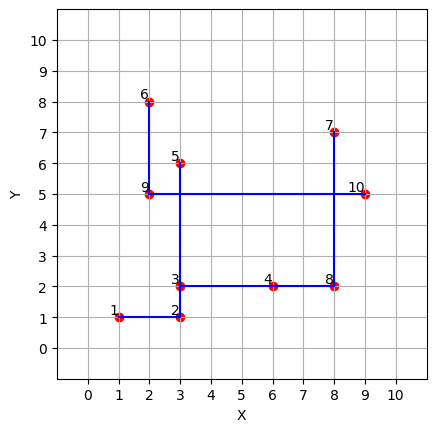

[(1, 2, 1), (2, 3, 1), (3, 4, 1), (3, 5, 1), (4, 8, 1), (6, 9, 1), (7, 8, 1), (9, 10, 1)]
dict_items([(1, ((1,1),(3,1))), (2, ((3,1),(3,2))), (3, ((3,2),(6,2))), (4, ((3,2),(3,6))), (5, ((6,2),(8,2))), (6, ((2,8),(2,5))), (7, ((8,7),(8,2))), (8, ((2,5),(9,5)))])


In [9]:
# First, initialize the game putting as many lines as possible in the graph.
# In our case, we'll put lines which respect the condition of the game,
# therefore no lines in diagonal, but only vertical or horizontal.

# Method to not add twice the same edge
def exists_edge(lines,new_line):
  for line in lines.values():
    p1 = line.get_p1()
    p2 = line.get_p2()
    #print(f"p1: {p1}, p2: {p2}, new_line: {new_line}")
    if (p1 == new_line.get_p2() and p2==new_line.get_p1()):
      return True
  return False

def no_overlaps_edge(graph, vertices, line):
    if line.get_p1().get_x() < line.get_p2().get_x():
      x1,x2 = line.get_p1().get_x(),line.get_p2().get_x()
    else:
      x1,x2 = line.get_p2().get_x(),line.get_p1().get_x()

    if line.get_p1().get_y() < line.get_p2().get_y():
      y1,y2 = line.get_p1().get_y(),line.get_p2().get_y()
    else:
      y1,y2 = line.get_p2().get_y(),line.get_p1().get_y()



    for edge in graph.get_edges():
        first_point = vertices[edge[0]]
        second_point = vertices[edge[1]]

        # Horizontal case
        if y1 == y2 and y1 == first_point.get_y() and y1 == second_point.get_y():
            #print(f"I want to add the edges: {line}")
            #print(f"Horizontal case: {y1}, first_point {first_point}, second_point{second_point}.")
            if x1 <= first_point.get_x() and second_point.get_x()<=x2 and first_point.get_x() < second_point.get_x():
                return True  # Overlaps
            elif x1 <= second_point.get_x() and  first_point.get_x()<=x2 and first_point.get_x() > second_point.get_x():
              return True
        # Vertical case
        elif x1 == x2 and x1 == first_point.get_x() and x1 == second_point.get_x():
            if y1 >= first_point.get_y() and y2 <= second_point.get_y() and first_point.get_y() < second_point.get_y():
                return True  # Overlaps

    return False  # No overlaps found
def print_vertices_edges(graph,vertices):
  # Method to print the edges for each vertex
  index_keys = graph.get_adjacency_list().keys()
  print(index_keys)
  for i in index_keys:
    linked_nodes = graph.get_adjacency_list().get(i)
    for j in range (len(linked_nodes)):
      print(f"{vertices[i]} ----- {vertices[linked_nodes[j][0]]}")
      #print(linked_nodes[j])

def shortest_edge(line,lines):
  # First, I compute the difference between the two point of the current line
  diff = 0
  if (line.get_p1().x == line.get_p2().x):
    diff = abs(line.get_p2().y - line.get_p1().y)
  elif (line.get_p1().y == line.get_p2().y):
    diff = abs(line.get_p2().x - line.get_p1().x)

  # then I iterate on lines and if there is a line with the same coordinates in x or y of the current line and
  # whose difference on the opposite coordinates is shorter, I cannot add this edge

  for l in lines.values():
    # If they share the same x coordinates, let's check the difference in y.
    if (l.get_p1().x == l .get_p2().x and line.get_p1().x == line.get_p2().x and line.get_p1().x == l.get_p1().x):
      diff_l = abs(l.get_p2().y - l.get_p1().y)
      if (diff_l<diff):
        print("I cannot add this line.")


def calculate_distance(p1, p2):
    return math.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)

def initialize_graph(points):
  vertices = {}
  for index in range(len(points)):
    vertices[index+1] = points[index]

  graph = Graph()

  for i in vertices.keys():
    graph.add_vertex(i)
  lines = {}
  current_index = 1

  for i in range(len(points)):
    first_node = i+1
    source_node = points[i]
    for j in range(i+1,len(points)):
      final_node =j+1
      destination_node = points[j]
      if (source_node.x == destination_node.x and source_node.y!=destination_node.y) or (source_node.y==destination_node.y and source_node.x!=destination_node.x):
        line = Line(source_node,destination_node)
        shortest_edge = True
        for k in range(len(points)):
          if k!=i and k!=j:
            index_check_node = k+1
            check_node = points[k]
            if points[i].x == points[j].x and points[k].x == points[i].x:
              if points[i].y < points[k].y < points[j].y or points[i].y > points[k].y > points[j].y:
                shortest_edge = False
                break
            elif points[i].y == points[j].y and points[k].y == points[i].y:
              if points[i].x < points[k].x < points[j].x or points[i].x > points[k].x > points[j].x:
                shortest_edge = False
                break
      else:
        shortest_edge = False

      if shortest_edge:
        lines[current_index] = line
        #lines[current_index] = (first_node,final_node)
        current_index = current_index+1
        graph.add_edge(first_node,final_node,1)

  print(graph.get_adjacency_list())
  plot_graph([p for p in points],lines)
  print(graph.get_edges())

  return graph,vertices,lines



p1 = Point(1,1)
p2 = Point (3,1)
p3 = Point (3,2)
p4 = Point (6,2)
p5 = Point (3,6)
p6 = Point (2,8)
p7 = Point (8,7)
p8 = Point (8,2)
p9 = Point (2,5)
p10 = Point(9,5)
points = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
print(points)
graph,vertices,lines = initialize_graph(points)
print(lines.items())

In [10]:
print_vertices_edges(graph,vertices)

dict_keys([1, 2, 3, 4, 6, 7, 9])
(1,1) ----- (3,1)
(3,1) ----- (3,2)
(3,2) ----- (6,2)
(3,2) ----- (3,6)
(6,2) ----- (8,2)
(2,8) ----- (2,5)
(8,7) ----- (8,2)
(2,5) ----- (9,5)


In [11]:
def get_MST(graph):
  if (graph.is_connect()):
    tree = KruskalUnionFind(graph)
    mst_lines = {}
    current_index = 1
    for i in range(len(tree)):
      source_node = vertices[tree[i][0]]
      destination_node = vertices[tree[i][1]]
      current_line = Line(source_node,destination_node)
      mst_lines[current_index] = current_line
      current_index = current_index+1
    plot_graph([p for p in points],mst_lines)
  else:
    print("+++++++++++ GRAPH IS NOT CONNECTED +++++++++++")

get_MST(graph)

visited vertices:  {1, 2, 3, 4, 5, 8}
All vertices of the graph:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
+++++++++++ GRAPH IS NOT CONNECTED +++++++++++


# SAT SOLVER

The setting of the problem to be solved by using SAT starts by imposing some specific constrains.
As specified in the paper, the game has a solution if it respects the following property:

1.   No crossing lines
2.   iff exactly (p−1) of the Boolean variables in X are assigned true
3.   no cycles.



**FIRST CONSTRAINS**

In [12]:
# Method to print the edges for each vertex
def get_edges_graph(graph,vertices):
  index_keys = graph.get_adjacency_list().keys()
  edges=[]
  print(index_keys)
  for i in index_keys:
    linked_nodes = graph.get_adjacency_list().get(i)
    for j in range (len(linked_nodes)):
      #print(f"{vertices[i]} ----- {vertices[linked_nodes[j][0]]}")
      edges.append((vertices[i],vertices[linked_nodes[j][0]]))
  return edges

I create an example of graph where there exists a crossing link:

[(1,1), (3,1), (3,2), (6,2), (3,6), (2,8), (8,7), (8,2), (2,5), (9,5)]
defaultdict(<class 'list'>, {1: [(2, 1)], 2: [(3, 1)], 3: [(4, 1), (5, 1)], 4: [(8, 1)], 6: [(9, 1)], 7: [(8, 1)], 9: [(10, 1)]})


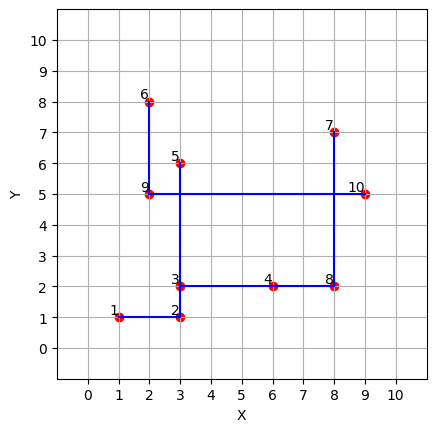

[(1, 2, 1), (2, 3, 1), (3, 4, 1), (3, 5, 1), (4, 8, 1), (6, 9, 1), (7, 8, 1), (9, 10, 1)]


In [13]:
p1 = Point(1,1)
p2 = Point (3,1)
p3 = Point (3,2)
p4 = Point (6,2)
p5 = Point (3,6)
p6 = Point (2,8)
p7 = Point (8,7)
p8 = Point (8,2)
p9 = Point (2,5)
p10 = Point(9,5)
points = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
print(points)
graph,vertices,lines = initialize_graph(points)

In [14]:
vertices.items()
print(lines.items())

dict_items([(1, ((1,1),(3,1))), (2, ((3,1),(3,2))), (3, ((3,2),(6,2))), (4, ((3,2),(3,6))), (5, ((6,2),(8,2))), (6, ((2,8),(2,5))), (7, ((8,7),(8,2))), (8, ((2,5),(9,5)))])


In [15]:
# We get a crossin lines only when the two lines are one vertical and the other horizontal.
# Two vertical lines or two horizontal lines will never cross one each other, of course if they are parallel.
# The only thing that can happen in this case, is that the coordinates of a line can be in the middle of the other line when they have the same x or y.
# Is it this possible (?)

def check_crossing_lines(l1,l2):
  # First condition
  l1_p1 = l1.get_p1()
  l1_p2 = l1.get_p2()
  #print(l1_p1,l1_p2)

  l2_p1 = l2.get_p1()
  l2_p2 = l2.get_p2()

  # So, first we check if l1 is horizontal or vertical.
  # HORIZONTAL CASE
  if (l1_p1.get_x() == l1_p2.get_x()):
    # To be sure to check the coordinates correctly, let's set x1,x2 in such way to have x1 < x2.
    if l2_p1.get_x() < l2_p2.get_x():
      x1,x2 = l2_p1.get_x(),l2_p2.get_x()
    else:
      x1,x2 = l2_p2.get_x(),l2_p1.get_x()
    # Check that the second line is vertical!
    if (l2_p1.get_y() == l2_p2.get_y()):
      # Now there can be an intersection of the two lines, let's check the coordinates.
      if (l1_p1.get_y()<l1_p2.get_y()):
        y1,y2 = l1_p1.get_y(), l1_p2.get_y()
      else:
        y1,y2 = l1_p2.get_y(),l1_p1.get_y()
      return (l1_p1.get_x()  > x1 and l1_p1.get_x()  < x2) and (l2_p1.get_y() > y1 and l2_p1.get_y() < y2)
    # Case in which both lines are horizontal
    else:
      return False

  # VERTICAL CASE
  if (l1_p1.get_y()==l1_p2.get_y()):
    if l2_p1.get_y() < l2_p2.get_y():
      y1,y2 = l2_p1.get_y(),l2_p2.get_y()
    else:
      y1,y2 = l2_p2.get_y(),l2_p1.get_y()
    # Check that the second line is horizontal!
    if (l2_p1.get_x() == l2_p2.get_x()):
      # Again, check if there is an intersection between two lines.
      if (l1_p1.get_x()<l1_p2.get_x()):
        x1,x2 =l1_p1.get_x(),l1_p2.get_x()
      else:
        x1,x2 =l1_p2.get_x(),l1_p1.get_x()
      return (l1_p1.get_y() > y1 and l1_p1.get_y() < y2) and ( l2_p1.get_x() > x1 and l2_p1.get_x() < x2 )
    else:
      return False

def get_key(my_dict, val):
  for key, value in my_dict.items():
      if val == value:
          return key
  return "key doesn't exist"

def check_reverse_order(lst, element):
    reverse_element = [element[1], element[0]]
    return reverse_element in lst

def no_crossing_lines(lines):
  cnf = WCNF()
  clauses = []
  for l1 in lines.values():
    for l2 in lines.values():
      # If check crossing lines, it is not possible to use togheter l1 and l2,
      # Therefore we create a clauses which puts in conjunction the negation of l1 and l2.
      if check_crossing_lines(l1,l2) == True:
        l1_key = get_key(lines,l1)
        l2_key = get_key(lines,l2)
        if not check_reverse_order(clauses,[-l1_key,-l2_key]):
          #print(f"l1 is: {l1}, l1_key: {l1_key}, l2 is: {l2}, l2_key: {l2_key}")
          clauses.append([-l1_key,-l2_key])
  for c in clauses:
    cnf.append(c)
  #print(cnf.clauses)
  return cnf

In [16]:
print(vertices.items())
print(lines.items())

dict_items([(1, (1,1)), (2, (3,1)), (3, (3,2)), (4, (6,2)), (5, (3,6)), (6, (2,8)), (7, (8,7)), (8, (8,2)), (9, (2,5)), (10, (9,5))])
dict_items([(1, ((1,1),(3,1))), (2, ((3,1),(3,2))), (3, ((3,2),(6,2))), (4, ((3,2),(3,6))), (5, ((6,2),(8,2))), (6, ((2,8),(2,5))), (7, ((8,7),(8,2))), (8, ((2,5),(9,5)))])


In [17]:
print(vertices.items())
print(lines.items())
no_crossing_lines(lines).hard

dict_items([(1, (1,1)), (2, (3,1)), (3, (3,2)), (4, (6,2)), (5, (3,6)), (6, (2,8)), (7, (8,7)), (8, (8,2)), (9, (2,5)), (10, (9,5))])
dict_items([(1, ((1,1),(3,1))), (2, ((3,1),(3,2))), (3, ((3,2),(6,2))), (4, ((3,2),(3,6))), (5, ((6,2),(8,2))), (6, ((2,8),(2,5))), (7, ((8,7),(8,2))), (8, ((2,5),(9,5)))])


[[-4, -8], [-7, -8]]

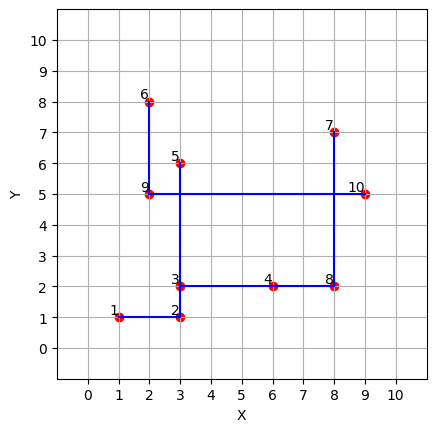

In [18]:
plot_graph(points,lines)

In [19]:
print(get_edges_graph(graph,vertices))

dict_keys([1, 2, 3, 4, 6, 7, 9])
[((1,1), (3,1)), ((3,1), (3,2)), ((3,2), (6,2)), ((3,2), (3,6)), ((6,2), (8,2)), ((2,8), (2,5)), ((8,7), (8,2)), ((2,5), (9,5))]


**SECOND CONSTRAINT**

To express the constraint "exactly k lines" I will use the formula expressed during the lesson for which it is expressed with two constrains of having at list n-k+1 lines and at most +1.

In our case, the elements to iterate are agains the keys of lines, for which we have expressed also the previous constraint.
n is the number of keys.
To express the possible combination I'll use the method combinations of itertools' library.



In [20]:
import itertools

def exactly_k(literal_list,k):
  clauses = []
  n = len(literal_list)

  # at least k
  combs=list(itertools.combinations(literal_list,n-k+1))
  for sub_lists in combs:
    clauses.append(list(sub_lists))

  # at most k
  combs = list (itertools.combinations(literal_list,k+1))
  for sub_lists in combs:
    temp = [-i for i in list(sub_lists)]
    clauses.append(temp)

  return clauses

In [21]:
k = (len(points)-1)
exactly_k(lines.keys(),k)

[[]]

**Third constraint**



I create an example to test the third constraint -> a graph with an inner cycle

defaultdict(<class 'list'>, {1: [(2, 1), (6, 1)], 2: [(3, 1)], 3: [(4, 1)], 4: [(5, 1)], 5: [(7, 1)], 6: [(7, 1), (8, 1)]})


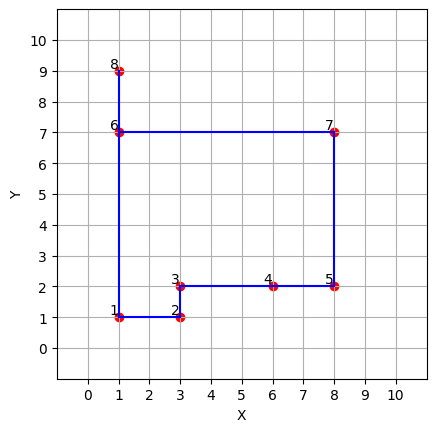

[(1, 2, 1), (1, 6, 1), (2, 3, 1), (3, 4, 1), (4, 5, 1), (5, 7, 1), (6, 7, 1), (6, 8, 1)]


In [22]:
# A vertex is an tuple of an integer which represents it and a point
# vertex v = (1,p1) -> this is what i want.
p1 = Point(1,1)
p2 = Point (3,1)
p3 = Point (3,2)
p4 = Point (6,2)
p5 = Point (8,2)
p6 = Point (1,7)
p7 = Point (8,7)
p8 = Point (1,9)

points = [p1,p2,p3,p4,p5,p6,p7,p8]

graph,vertices,lines = initialize_graph(points)



In [23]:
vertices.items()

dict_items([(1, (1,1)), (2, (3,1)), (3, (3,2)), (4, (6,2)), (5, (8,2)), (6, (1,7)), (7, (8,7)), (8, (1,9))])

In [24]:
#lines.items()
#vertices.items()
lines.items()

dict_items([(1, ((1,1),(3,1))), (2, ((1,1),(1,7))), (3, ((3,1),(3,2))), (4, ((3,2),(6,2))), (5, ((6,2),(8,2))), (6, ((8,2),(8,7))), (7, ((1,7),(8,7))), (8, ((1,7),(1,9)))])

In [25]:
def DFS(graph):
    visited = set()  # Set to keep track of visited vertices
    parent = {}  # Dictionary to store parent vertices during DFS traversal
    path = []

    def DFS_visit(vertex, parent_vertex):
        visited.add(vertex)
        for neighbor_data in graph.get_adjacency_list()[vertex]:
            neighbor = neighbor_data[0]

            #print(f"Vertex: {vertex}, neighbor: {neighbor}")
            if neighbor not in visited:
                path.append((vertex,neighbor))
                parent[neighbor] = vertex
                if DFS_visit(neighbor, vertex):  # Recursively visit the neighbor
                    return True
            elif parent.get(vertex) != neighbor and neighbor != parent_vertex:
                # If the neighbor is already visited and it's not the parent of the current vertex,
                # then there is a cycle
                #print(f"I'm the vertex: {vertex}, my parent is: {parent.get(vertex)}, my neighbor is: {neighbor}")
                #print(f"My neighbor {neighbor} has already been visited by {parent.get(neighbor)}, therefore there exists a cycle here!")
                path.append((vertex,neighbor))
                return True

        return False

    # Perform DFS traversal for each unvisited vertex in the graph
    for vertex in graph.get_vertices():
        #print(f"Vertex is: {vertices[vertex]}")
        if vertex not in visited:
            if DFS_visit(vertex, None):
                #print(visited)
                #print(path)
                return True,path  # If cycle found, return True

    return False,path  # No cycle found in the graph


def get_key_lines(lines, val):
  for key, value in lines.items():
      if val.get_p1() == value.get_p1() and val.get_p2() == value.get_p2() or val.get_p1() == value.get_p2() and val.get_p2() == value.get_p1():
          return key
  return "key doesn't exist"


def no_cycles(graph):
  # Call DFS method
  has_cycle,path = DFS(graph)

  cnf = CNF()
  formula=[]
  # Check if a cycle exists
  if has_cycle:
    print("The graph contains a cycle.")
    for line in path:
      p1 = vertices[line[0]]
      p2 = vertices[line[1]]
      l = Line(p1,p2)
      formula.append(get_key_lines(lines,l))
      #cnf.extend([-get_key_lines(lines,l)])
  cnf.append(formula)
  print(cnf.clauses)
  return cnf
  #else:
  #  print("The graph does not contain a cycle.")

In [26]:
graph.get_edges()
edges = [[t[0], t[1]] for t in graph.get_edges()]
print(edges)

[[1, 2], [1, 6], [2, 3], [3, 4], [4, 5], [5, 7], [6, 7], [6, 8]]


In [27]:
no_cycles(graph).clauses

The graph contains a cycle.
[[1, 3, 4, 5, 6, 2, 7]]


[[1, 3, 4, 5, 6, 2, 7]]

# **FIRST POINT**

Decide if there is a solution for G. If there is, return one solution.



Each sat variable has to stand for a line!

In [28]:
def all_cycles(graph):
  edges = [[t[0], t[1]] for t in graph.get_edges()]
  cycles = []

  def get_cycles():
      for edge in edges:
          for node in edge:
              findNewCycles([node])
      final_cycles= []
      current_index=0
      for cy in cycles:
          path = [(int(node)) for node in cy]
          #path.append(-int(cycles[current_index][0]))
          current_index = current_index+1
          final_cycles.append(path)
      print(final_cycles)
      return final_cycles

  def findNewCycles(path):
      start_node = path[0]
      next_node= None
      sub = []

      #visit each edge and each node of each edge
      for edge in edges:
          node1, node2 = edge
          if start_node in edge:
                  if node1 == start_node:
                      next_node = node2
                  else:
                      next_node = node1
                  if not visited(next_node, path):
                          # neighbor node not on path yet
                          sub = [next_node]
                          sub.extend(path)
                          # explore extended path
                          findNewCycles(sub);
                  elif len(path) > 2  and next_node == path[-1]:
                          # cycle found
                          p = rotate_to_smallest(path);
                          inv = invert(p)
                          if isNew(p) and isNew(inv):
                            cycles.append(p)
                          #if isNew(p) and isNew(inv):
                          #    cycles.append(p)

  def invert(path):
      return rotate_to_smallest(path[::-1])

  #  rotate cycle path such that it begins with the smallest node
  def rotate_to_smallest(path):
      n = path.index(min(path))
      return path[n:]+path[:n]

  def isNew(path):
      return not path in cycles

  def visited(node, path):
      return node in path

  return get_cycles()

third_constraint = all_cycles(graph)
print(third_constraint)

def create_constraint_edges(arr,vertices,lines):
    tuples = []
    for i in range(len(arr) - 1):
        #print(f"Current vertices: {vertices[arr[i]], vertices[arr[i+1]]})")
        line = Line(vertices[arr[i]],vertices[arr[i+1]])
        key_line = get_key_lines(lines,line)
        #print(f"Key line is: {key_line}")
        tuples.append(-key_line)
    return tuples

[[1, 6, 7, 5, 4, 3, 2]]
[[1, 6, 7, 5, 4, 3, 2]]


I cicli vengono forniti sottoforma di vertici
Devo formare per ogni coppia successiva xi-x(i+1) l'arco e da lì ricavare la chiave dell'items e formare la clauses.

In [29]:
def find_solution(graph,lines,points,vertices):
  solver = Minisat22()

  # Call DFS method
  has_cycle,path = DFS(graph)
  cnf = WCNF()

  # Addition of the first constraint
  print(f"No_crossing_lines: {no_crossing_lines(lines).hard}")
  first_contraint = no_crossing_lines(lines)
  k = len(points) - 1
  print(f"K is: {k}")

  # Addition of the second constraint
  #print(f"exactly_k: {exactly_k(lines.keys(),k).clauses}")


  # Addition of the third constraint.
  if (has_cycle):
    third_constraint = all_cycles(graph)
    cycles_constraint=WCNF()
    for elem in third_constraint:
      cycles_constraint.append(create_constraint_edges(elem,vertices,lines))

    cnf.extend(cycles_constraint.hard)
    cnf.extend(first_contraint.hard)
    cnf.extend(exactly_k(lines.keys(),k))
    print(f"Clauses: {cnf.hard}")
    # SOLUTION
    solver.append_formula(cnf.hard)
    solution = solver.solve()

    if solution:
      model = solver.get_model()
      model_lines = {x: lines[x] for x in model if x > 0}
      print(f"Model is: {model}")
      print(f"Model_lines: {model_lines}")
      plot_graph(points,model_lines)
      print(solver.enum_models())
    else:
      print("No solution")
  else:
    print("No solution")

# **SECOND POINT**

Decide if there is a solution for G. If
there is, return the number of solutions.

In [63]:
def get_number_solution(graph,lines,points,vertices):
  solver = Minisat22()

  # Call DFS method
  has_cycle,path = DFS(graph)
  cnf = WCNF()

  # Addition of the first constraint
  print(f"No_crossing_lines: {no_crossing_lines(lines).hard}")
  first_contraint = no_crossing_lines(lines)
  k = len(points) - 1
  print(f"K is: {k}")

  # Addition of the second constraint
  #print(f"exactly_k: {exactly_k(lines.keys(),k).clauses}")


  # Addition of the third constraint.
  if (has_cycle):
    third_constraint = all_cycles(graph)
    cycles_constraint=WCNF()
    for elem in third_constraint:
      cycles_constraint.append(create_constraint_edges(elem,vertices,lines))

    cnf.extend(cycles_constraint.hard)
    cnf.extend(first_contraint.hard)
    cnf.extend(exactly_k(lines.keys(),k))
    print(f"Clauses: {cnf.hard}")
    # SOLUTION
    solver.append_formula(cnf.hard)
    solution = solver.solve()

    if solution:
      n_sol = 0
      for _ in solver.enum_models():
        n_sol += 1
      print("Number of solutions: ", n_sol)
    else:
      print("No solution")
  else:
    print("No solution")

# Method to plot all possible solutions
def plot_all_solutions(graph,lines,points,vertices):
  solver = Minisat22()

  # Call DFS method
  has_cycle,path = DFS(graph)
  cnf = WCNF()

  # Addition of the first constraint
  print(f"No_crossing_lines: {no_crossing_lines(lines).hard}")
  first_contraint = no_crossing_lines(lines)
  k = len(points) - 1
  print(f"K is: {k}")

  # Addition of the second constraint
  #print(f"exactly_k: {exactly_k(lines.keys(),k).clauses}")


  # Addition of the third constraint.
  if (has_cycle):
    third_constraint = all_cycles(graph)
    cycles_constraint=WCNF()
    for elem in third_constraint:
      cycles_constraint.append(create_constraint_edges(elem,vertices,lines))

    cnf.extend(cycles_constraint.hard)
    cnf.extend(first_contraint.hard)
    cnf.extend(exactly_k(lines.keys(),k))
    print(f"Clauses: {cnf.hard}")
    # SOLUTION
    solver.append_formula(cnf.hard)
    solution = solver.solve()

    if solution:
      n_sol = 0
      for model in solver.enum_models():
        n_sol += 1
        model_lines = {x: lines[x] for x in model if x > 0}
        print(f"Model is: {model}")
        print(f"Model_lines: {model_lines}")
        plot_graph(points,model_lines)
      print("Number of solutions: ", n_sol)

    else:
      print("No solution")
  else:
    print("No solution")

# **THIRD POINT**

Decide if there is a solution for G. If there
is, return a minimum-length solution.

In [64]:
def euclidian_distance(p1, p2):
    x1 = p1.get_x()
    x2 = p2.get_x()
    y1 = p1.get_y()
    y2 = p2.get_y()
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [65]:
lines.values()

dict_values([((1,1),(1,4)), ((1,1),(4,1)), ((1,7),(1,4)), ((1,7),(4,7)), ((4,4),(1,4)), ((4,4),(4,1)), ((4,4),(4,7))])

In [93]:
def get_minimum_lenght_constraint(lines):
  formulas = WCNF()
  for line in lines.values():
    peso = euclidian_distance(line.get_p1(),line.get_p2())
    formulas.append([get_key_lines(lines,line)],weight=-peso)
    #print(euclidian_distance(line.get_p1(),line.get_p2()))
    #print(get_key_lines(lines,line))
  print(formulas.soft)
  return formulas

get_minimum_lenght_constraint(lines)

[[1], [2], [3], [4], [5], [6], [7]]


WCNF(from_string="p wcnf 7 7 -20.0\n-3.0 1 0\n-3.0 2 0\n-3.0 3 0\n-3.0 4 0\n-3.0 5 0\n-3.0 6 0\n-3.0 7 0\n")

In [100]:
def get_minimum_lenght_solution(graph,lines,points,vertices):
  solver = Minisat22()

  # Call DFS method
  has_cycle,path = DFS(graph)
  cnf = WCNF()

  # Addition of the first constraint
  print(f"No_crossing_lines: {no_crossing_lines(lines).hard}")
  first_contraint = no_crossing_lines(lines)
  k = len(points) - 1
  print(f"K is: {k}")

  # Addition of the second constraint
  #print(f"exactly_k: {exactly_k(lines.keys(),k).clauses}")


  # Addition of the third constraint.
  if (has_cycle):
    third_constraint = all_cycles(graph)
    cycles_constraint=WCNF()
    for elem in third_constraint:
      cycles_constraint.append(create_constraint_edges(elem,vertices,lines))

    cnf.extend(cycles_constraint.hard)
    cnf.extend(first_contraint.hard)
    cnf.extend(exactly_k(lines.keys(),k))

    minimum_lenght_constraint = get_minimum_lenght_constraint(lines)
    cnf.extend(minimum_lenght_constraint.soft,weights=minimum_lenght_constraint.wght)
    solver = FM(cnf,verbose=0)

    # SOLUTION
    solution = solver.compute()

    if solution:
      model = solver.model
      model_lines = {x: lines[x] for x in model if x > 0}
      plot_graph(points,model_lines)
    else:
      print("No solution")
  else:
    print("No solution")

In [ ]:
get_minimum_lenght_solution(graph,lines,points,vertices)

# Examples

**ESEMPIO PROVA CON FILIPPO**

defaultdict(<class 'list'>, {1: [(2, 1), (6, 1)], 2: [(9, 1)], 3: [(4, 1), (10, 1)], 4: [(7, 1)], 5: [(8, 1)], 6: [(7, 1), (13, 1)], 7: [(11, 1)], 8: [(9, 1), (15, 1)], 10: [(11, 1)], 11: [(12, 1)], 13: [(14, 1)], 14: [(15, 1)]})


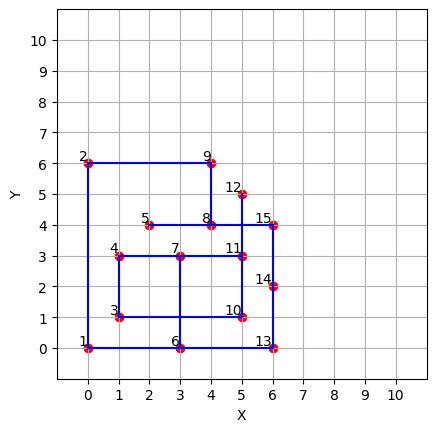

[(1, 2, 1), (1, 6, 1), (2, 9, 1), (3, 4, 1), (3, 10, 1), (4, 7, 1), (5, 8, 1), (6, 7, 1), (6, 13, 1), (7, 11, 1), (8, 9, 1), (8, 15, 1), (10, 11, 1), (11, 12, 1), (13, 14, 1), (14, 15, 1)]


In [102]:
p0 = Point(0,0)
p1=Point(0,6)
p2=Point(1,1)
p3=Point(1,3)
p4=Point(2,4)
p5=Point(3,0)
p6=Point(3,3)
p7=Point(4,4)
p8=Point(4,6)
p9=Point(5,1)
p10=Point(5,3)
p11=Point(5,5)
p12=Point(6,0)
p13=Point(6,2)
p14=Point(6,4)
points = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14]

graph,vertices,lines = initialize_graph(points)

In [31]:
print(vertices.items())
print(lines.items())
no_crossing_lines(lines).hard

dict_items([(1, (0,0)), (2, (0,6)), (3, (1,1)), (4, (1,3)), (5, (2,4)), (6, (3,0)), (7, (3,3)), (8, (4,4)), (9, (4,6)), (10, (5,1)), (11, (5,3)), (12, (5,5)), (13, (6,0)), (14, (6,2)), (15, (6,4))])
dict_items([(1, ((0,0),(0,6))), (2, ((0,0),(3,0))), (3, ((0,6),(4,6))), (4, ((1,1),(1,3))), (5, ((1,1),(5,1))), (6, ((1,3),(3,3))), (7, ((2,4),(4,4))), (8, ((3,0),(3,3))), (9, ((3,0),(6,0))), (10, ((3,3),(5,3))), (11, ((4,4),(4,6))), (12, ((4,4),(6,4))), (13, ((5,1),(5,3))), (14, ((5,3),(5,5))), (15, ((6,0),(6,2))), (16, ((6,2),(6,4)))])


[[-5, -8], [-12, -14]]

In [32]:
print(lines.items())
#all_cycles(graph)

dict_items([(1, ((0,0),(0,6))), (2, ((0,0),(3,0))), (3, ((0,6),(4,6))), (4, ((1,1),(1,3))), (5, ((1,1),(5,1))), (6, ((1,3),(3,3))), (7, ((2,4),(4,4))), (8, ((3,0),(3,3))), (9, ((3,0),(6,0))), (10, ((3,3),(5,3))), (11, ((4,4),(4,6))), (12, ((4,4),(6,4))), (13, ((5,1),(5,3))), (14, ((5,3),(5,5))), (15, ((6,0),(6,2))), (16, ((6,2),(6,4)))])


In [33]:
lines.items()

dict_items([(1, ((0,0),(0,6))), (2, ((0,0),(3,0))), (3, ((0,6),(4,6))), (4, ((1,1),(1,3))), (5, ((1,1),(5,1))), (6, ((1,3),(3,3))), (7, ((2,4),(4,4))), (8, ((3,0),(3,3))), (9, ((3,0),(6,0))), (10, ((3,3),(5,3))), (11, ((4,4),(4,6))), (12, ((4,4),(6,4))), (13, ((5,1),(5,3))), (14, ((5,3),(5,5))), (15, ((6,0),(6,2))), (16, ((6,2),(6,4)))])

No_crossing_lines: [[-5, -8], [-12, -14]]
K is: 14
[[1, 6, 13, 14, 15, 8, 9, 2], [3, 10, 11, 7, 4]]
Clauses: [[-2, -9, -15, -16, -12, -11, -3], [-5, -13, -10, -6], [-5, -8], [-12, -14], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 2, 8], [1, 2, 9], [1, 2, 10], [1, 2, 11], [1, 2, 12], [1, 2, 13], [1, 2, 14], [1, 2, 15], [1, 2, 16], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 3, 9], [1, 3, 10], [1, 3, 11], [1, 3, 12], [1, 3, 13], [1, 3, 14], [1, 3, 15], [1, 3, 16], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 4, 9], [1, 4, 10], [1, 4, 11], [1, 4, 12], [1, 4, 13], [1, 4, 14], [1, 4, 15], [1, 4, 16], [1, 5, 6], [1, 5, 7], [1, 5, 8], [1, 5, 9], [1, 5, 10], [1, 5, 11], [1, 5, 12], [1, 5, 13], [1, 5, 14], [1, 5, 15], [1, 5, 16], [1, 6, 7], [1, 6, 8], [1, 6, 9], [1, 6, 10], [1, 6, 11], [1, 6, 12], [1, 6, 13], [1, 6, 14], [1, 6, 15], [1, 6, 16], [1, 7, 8], [1, 7, 9], [1, 7, 10], [1, 7, 11], [1, 7, 12], [1, 7, 13], [1, 7, 14], [1, 7, 15], [1, 7, 16], [1, 8, 9], [1

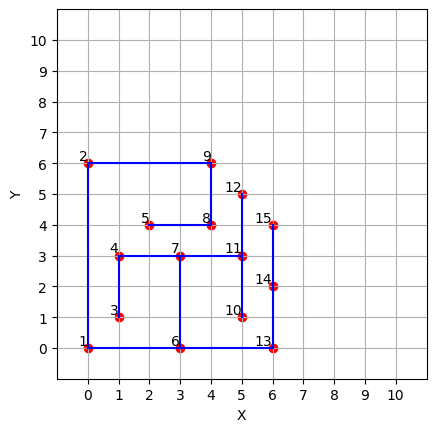

<generator object Minisat22.enum_models at 0x7f98da822c00>


In [103]:
find_solution(graph,lines,points,vertices)

In [105]:
get_number_solution(graph,lines,points,vertices)


No_crossing_lines: [[-5, -8], [-12, -14]]
K is: 14
[[1, 6, 13, 14, 15, 8, 9, 2], [3, 10, 11, 7, 4]]
Clauses: [[-2, -9, -15, -16, -12, -11, -3], [-5, -13, -10, -6], [-5, -8], [-12, -14], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 2, 8], [1, 2, 9], [1, 2, 10], [1, 2, 11], [1, 2, 12], [1, 2, 13], [1, 2, 14], [1, 2, 15], [1, 2, 16], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 3, 9], [1, 3, 10], [1, 3, 11], [1, 3, 12], [1, 3, 13], [1, 3, 14], [1, 3, 15], [1, 3, 16], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 4, 9], [1, 4, 10], [1, 4, 11], [1, 4, 12], [1, 4, 13], [1, 4, 14], [1, 4, 15], [1, 4, 16], [1, 5, 6], [1, 5, 7], [1, 5, 8], [1, 5, 9], [1, 5, 10], [1, 5, 11], [1, 5, 12], [1, 5, 13], [1, 5, 14], [1, 5, 15], [1, 5, 16], [1, 6, 7], [1, 6, 8], [1, 6, 9], [1, 6, 10], [1, 6, 11], [1, 6, 12], [1, 6, 13], [1, 6, 14], [1, 6, 15], [1, 6, 16], [1, 7, 8], [1, 7, 9], [1, 7, 10], [1, 7, 11], [1, 7, 12], [1, 7, 13], [1, 7, 14], [1, 7, 15], [1, 7, 16], [1, 8, 9], [1

No_crossing_lines: [[-5, -8], [-12, -14]]
K is: 14
[[1, 6, 13, 14, 15, 8, 9, 2], [3, 10, 11, 7, 4]]
[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16]]


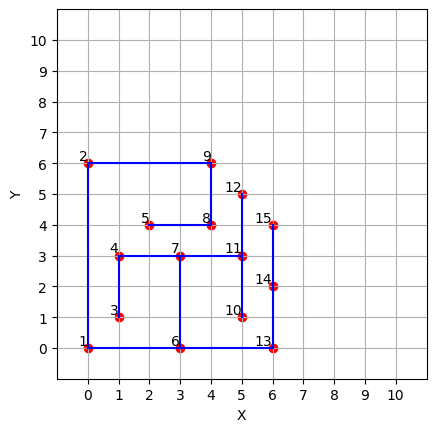

In [106]:
get_minimum_lenght_solution(graph,lines,points,vertices)

**First Example:**

Yashi Game with a cycle which has to be omitted.

defaultdict(<class 'list'>, {1: [(2, 1), (6, 1)], 2: [(3, 1)], 3: [(4, 1)], 4: [(5, 1)], 5: [(7, 1)], 6: [(7, 1), (8, 1)]})


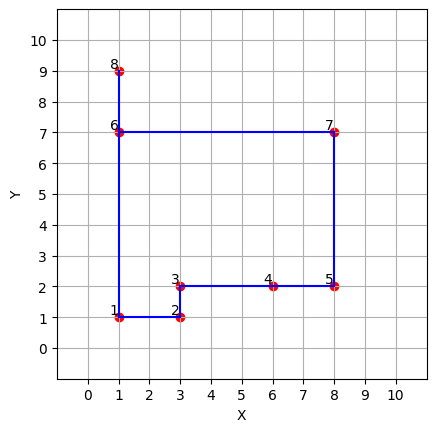

[(1, 2, 1), (1, 6, 1), (2, 3, 1), (3, 4, 1), (4, 5, 1), (5, 7, 1), (6, 7, 1), (6, 8, 1)]


In [109]:
# A vertex is an tuple of an integer which represents it and a point
# vertex v = (1,p1) -> this is what i want.
p1 = Point(1,1)
p2 = Point (3,1)
p3 = Point (3,2)
p4 = Point (6,2)
p5 = Point (8,2)
p6 = Point (1,7)
p7 = Point (8,7)
p8 = Point (1,9)

points = [p1,p2,p3,p4,p5,p6,p7,p8]

graph,vertices,lines = initialize_graph(points)



In [36]:
all_cycles(graph)

[[1, 6, 7, 5, 4, 3, 2]]


[[1, 6, 7, 5, 4, 3, 2]]

In [37]:
lines.items()

dict_items([(1, ((1,1),(3,1))), (2, ((1,1),(1,7))), (3, ((3,1),(3,2))), (4, ((3,2),(6,2))), (5, ((6,2),(8,2))), (6, ((8,2),(8,7))), (7, ((1,7),(8,7))), (8, ((1,7),(1,9)))])

No_crossing_lines: []
K is: 7
[[1, 6, 7, 5, 4, 3, 2]]
Clauses: [[-2, -7, -6, -5, -4, -3], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 5], [4, 6], [4, 7], [4, 8], [5, 6], [5, 7], [5, 8], [6, 7], [6, 8], [7, 8], [-1, -2, -3, -4, -5, -6, -7, -8]]
Model is: [1, -2, 3, 4, 5, 6, 7, 8]
Model_lines: {1: ((1,1),(3,1)), 3: ((3,1),(3,2)), 4: ((3,2),(6,2)), 5: ((6,2),(8,2)), 6: ((8,2),(8,7)), 7: ((1,7),(8,7)), 8: ((1,7),(1,9))}


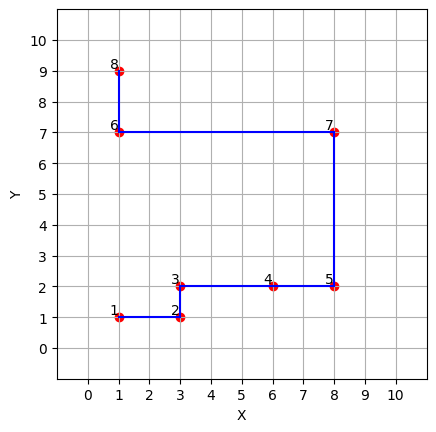

<generator object Minisat22.enum_models at 0x7f98da5ed8c0>


In [110]:
find_solution(graph,lines,points,vertices)

In [111]:
get_number_solution(graph,lines,points,vertices)


No_crossing_lines: []
K is: 7
[[1, 6, 7, 5, 4, 3, 2]]
Clauses: [[-2, -7, -6, -5, -4, -3], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 5], [4, 6], [4, 7], [4, 8], [5, 6], [5, 7], [5, 8], [6, 7], [6, 8], [7, 8], [-1, -2, -3, -4, -5, -6, -7, -8]]
Number of solutions:  6


No_crossing_lines: []
K is: 7
[[1, 6, 7, 5, 4, 3, 2]]
Clauses: [[-2, -7, -6, -5, -4, -3], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 5], [4, 6], [4, 7], [4, 8], [5, 6], [5, 7], [5, 8], [6, 7], [6, 8], [7, 8], [-1, -2, -3, -4, -5, -6, -7, -8]]
Model is: [1, -2, 3, 4, 5, 6, 7, 8]
Model_lines: {1: ((1,1),(3,1)), 3: ((3,1),(3,2)), 4: ((3,2),(6,2)), 5: ((6,2),(8,2)), 6: ((8,2),(8,7)), 7: ((1,7),(8,7)), 8: ((1,7),(1,9))}


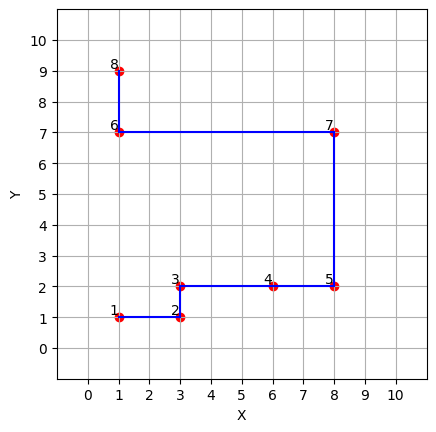

Model is: [1, 2, 3, 4, 5, -6, 7, 8]
Model_lines: {1: ((1,1),(3,1)), 2: ((1,1),(1,7)), 3: ((3,1),(3,2)), 4: ((3,2),(6,2)), 5: ((6,2),(8,2)), 7: ((1,7),(8,7)), 8: ((1,7),(1,9))}


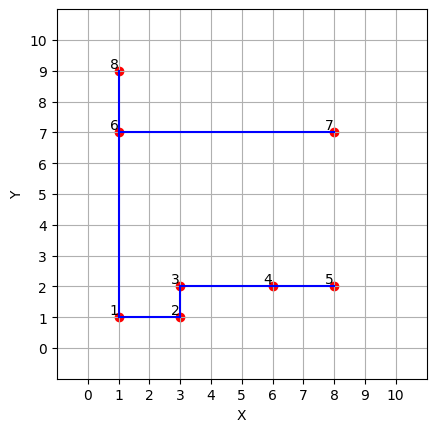

Model is: [1, 2, 3, -4, 5, 6, 7, 8]
Model_lines: {1: ((1,1),(3,1)), 2: ((1,1),(1,7)), 3: ((3,1),(3,2)), 5: ((6,2),(8,2)), 6: ((8,2),(8,7)), 7: ((1,7),(8,7)), 8: ((1,7),(1,9))}


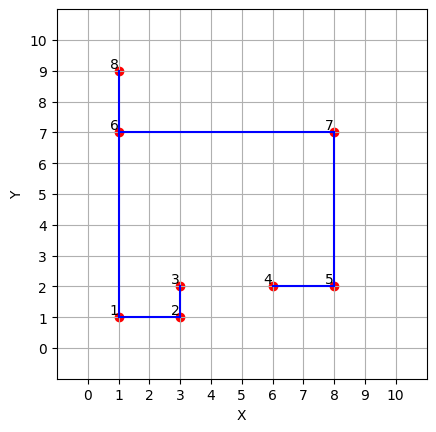

Model is: [1, 2, -3, 4, 5, 6, 7, 8]
Model_lines: {1: ((1,1),(3,1)), 2: ((1,1),(1,7)), 4: ((3,2),(6,2)), 5: ((6,2),(8,2)), 6: ((8,2),(8,7)), 7: ((1,7),(8,7)), 8: ((1,7),(1,9))}


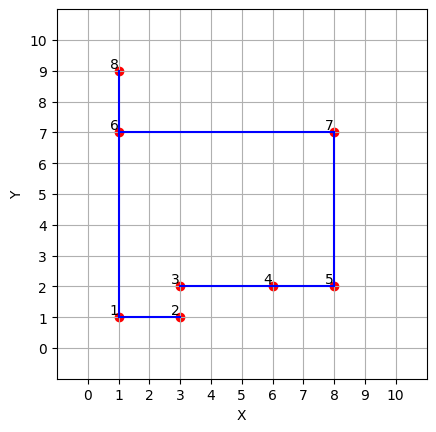

Model is: [1, 2, 3, 4, 5, 6, -7, 8]
Model_lines: {1: ((1,1),(3,1)), 2: ((1,1),(1,7)), 3: ((3,1),(3,2)), 4: ((3,2),(6,2)), 5: ((6,2),(8,2)), 6: ((8,2),(8,7)), 8: ((1,7),(1,9))}


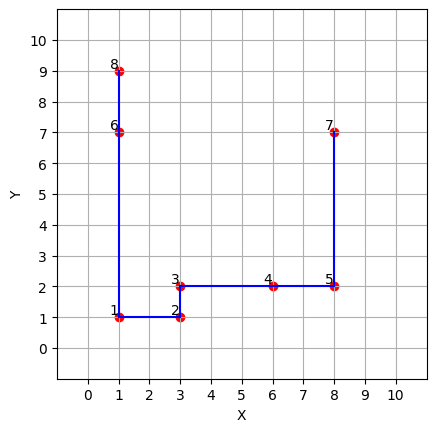

Model is: [1, 2, 3, 4, -5, 6, 7, 8]
Model_lines: {1: ((1,1),(3,1)), 2: ((1,1),(1,7)), 3: ((3,1),(3,2)), 4: ((3,2),(6,2)), 6: ((8,2),(8,7)), 7: ((1,7),(8,7)), 8: ((1,7),(1,9))}


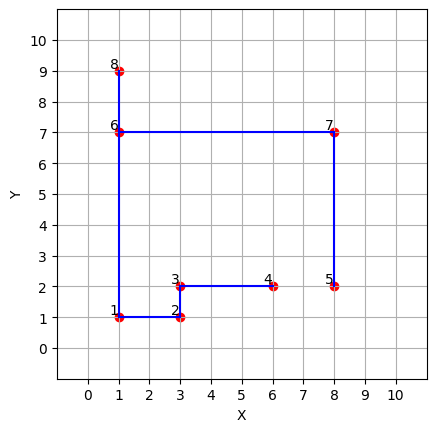

Number of solutions:  6


In [113]:
plot_all_solutions(graph,lines,points,vertices)

No_crossing_lines: []
K is: 7
[[1, 6, 7, 5, 4, 3, 2]]
[[1], [2], [3], [4], [5], [6], [7], [8]]


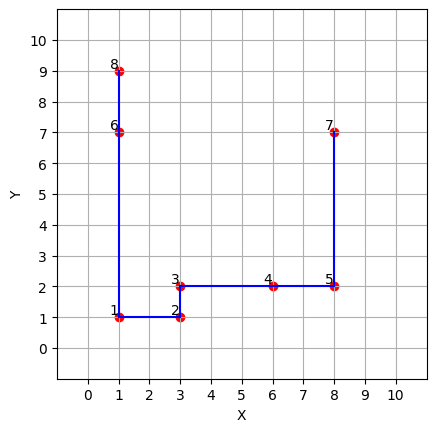

In [112]:
get_minimum_lenght_solution(graph,lines,points,vertices)

**Second example:**

Yashi Game with crossing lines -> no possible solution in this example.

[(1,1), (3,1), (3,2), (6,2), (3,6), (2,8), (8,7), (8,2), (2,5), (9,5)]
defaultdict(<class 'list'>, {1: [(2, 1)], 2: [(3, 1)], 3: [(4, 1), (5, 1)], 4: [(8, 1)], 6: [(9, 1)], 7: [(8, 1)], 9: [(10, 1)]})


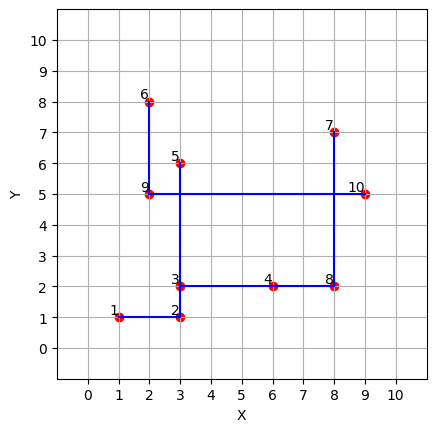

[(1, 2, 1), (2, 3, 1), (3, 4, 1), (3, 5, 1), (4, 8, 1), (6, 9, 1), (7, 8, 1), (9, 10, 1)]


In [39]:
p1 = Point(1,1)
p2 = Point (3,1)
p3 = Point (3,2)
p4 = Point (6,2)
p5 = Point (3,6)
p6 = Point (2,8)
p7 = Point (8,7)
p8 = Point (8,2)
p9 = Point (2,5)
p10 = Point(9,5)
points = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
print(points)
graph,vertices,lines = initialize_graph(points)

In [40]:
find_solution(graph,lines,points,vertices)

No_crossing_lines: [[-4, -8], [-7, -8]]
K is: 9
[]
Clauses: [[-4, -8], [-7, -8], []]
No solution


In [41]:
get_MST(graph)

visited vertices:  {1, 2, 3, 4, 5, 8}
All vertices of the graph:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
+++++++++++ GRAPH IS NOT CONNECTED +++++++++++


**Third Example**

Yashi-Game 7x7

[(1,1), (1,7), (2,4), (3,5), (4,1), (4,4), (5,5), (5,7), (6,2), (6,4), (6,6), (7,1), (7,3), (7,5), (2,2)]
defaultdict(<class 'list'>, {1: [(2, 1), (5, 1)], 2: [(8, 1)], 3: [(6, 1), (15, 1)], 4: [(7, 1)], 5: [(6, 1), (12, 1)], 6: [(10, 1)], 7: [(8, 1), (14, 1)], 9: [(10, 1), (15, 1)], 10: [(11, 1)], 12: [(13, 1)], 13: [(14, 1)]})


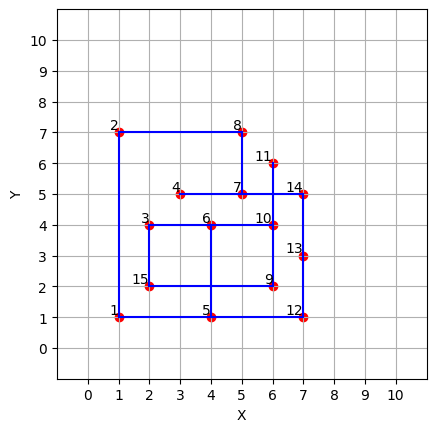

[(1, 2, 1), (1, 5, 1), (2, 8, 1), (3, 6, 1), (3, 15, 1), (4, 7, 1), (5, 6, 1), (5, 12, 1), (6, 10, 1), (7, 8, 1), (7, 14, 1), (9, 10, 1), (9, 15, 1), (10, 11, 1), (12, 13, 1), (13, 14, 1)]


In [117]:
p1 = Point(1,1)
p2 = Point(1,7)
p15 = Point(2,2)
p3 = Point(2,4)
p4 = Point(3,5)
p5 = Point(4,1)
p6 = Point(4,4)
p7 = Point(5,5)
p8 = Point(5,7)
p9 = Point(6,2)
p10 = Point(6,4)
p11 = Point(6,6)
p12 = Point(7,1)
p13 = Point (7,3)
p14 = Point (7,5)
points = [p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15]
print(points)
graph,vertices,lines = initialize_graph(points)

In [43]:
print(lines.items())
all_cycles(graph)

dict_items([(1, ((1,1),(1,7))), (2, ((1,1),(4,1))), (3, ((1,7),(5,7))), (4, ((2,4),(4,4))), (5, ((2,4),(2,2))), (6, ((3,5),(5,5))), (7, ((4,1),(4,4))), (8, ((4,1),(7,1))), (9, ((4,4),(6,4))), (10, ((5,5),(5,7))), (11, ((5,5),(7,5))), (12, ((6,2),(6,4))), (13, ((6,2),(2,2))), (14, ((6,4),(6,6))), (15, ((7,1),(7,3))), (16, ((7,3),(7,5)))])
[[1, 5, 12, 13, 14, 7, 8, 2], [3, 15, 9, 10, 6]]


[[1, 5, 12, 13, 14, 7, 8, 2], [3, 15, 9, 10, 6]]

In [44]:
no_crossing_lines(lines)

WCNF(from_string="p wcnf 14 2 1\n1 -7 -13 0\n1 -11 -14 0\n")

No_crossing_lines: [[-7, -13], [-11, -14]]
K is: 14
[[1, 5, 12, 13, 14, 7, 8, 2], [3, 15, 9, 10, 6]]
Clauses: [[-2, -8, -15, -16, -11, -10, -3], [-5, -13, -12, -9], [-7, -13], [-11, -14], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 2, 8], [1, 2, 9], [1, 2, 10], [1, 2, 11], [1, 2, 12], [1, 2, 13], [1, 2, 14], [1, 2, 15], [1, 2, 16], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 3, 9], [1, 3, 10], [1, 3, 11], [1, 3, 12], [1, 3, 13], [1, 3, 14], [1, 3, 15], [1, 3, 16], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 4, 9], [1, 4, 10], [1, 4, 11], [1, 4, 12], [1, 4, 13], [1, 4, 14], [1, 4, 15], [1, 4, 16], [1, 5, 6], [1, 5, 7], [1, 5, 8], [1, 5, 9], [1, 5, 10], [1, 5, 11], [1, 5, 12], [1, 5, 13], [1, 5, 14], [1, 5, 15], [1, 5, 16], [1, 6, 7], [1, 6, 8], [1, 6, 9], [1, 6, 10], [1, 6, 11], [1, 6, 12], [1, 6, 13], [1, 6, 14], [1, 6, 15], [1, 6, 16], [1, 7, 8], [1, 7, 9], [1, 7, 10], [1, 7, 11], [1, 7, 12], [1, 7, 13], [1, 7, 14], [1, 7, 15], [1, 7, 16], [1, 8, 9], 

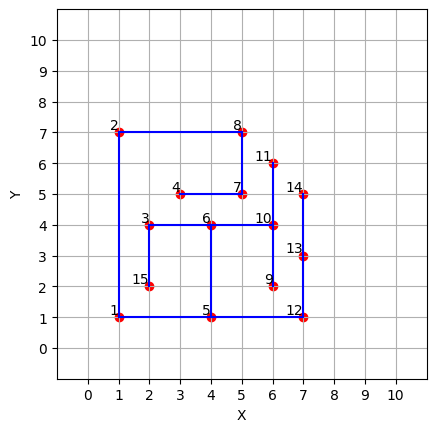

<generator object Minisat22.enum_models at 0x7f98da822810>


In [118]:
find_solution(graph,lines,points,vertices)

In [119]:
get_number_solution(graph,lines,points,vertices)


No_crossing_lines: [[-7, -13], [-11, -14]]
K is: 14
[[1, 5, 12, 13, 14, 7, 8, 2], [3, 15, 9, 10, 6]]
Clauses: [[-2, -8, -15, -16, -11, -10, -3], [-5, -13, -12, -9], [-7, -13], [-11, -14], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 2, 8], [1, 2, 9], [1, 2, 10], [1, 2, 11], [1, 2, 12], [1, 2, 13], [1, 2, 14], [1, 2, 15], [1, 2, 16], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 3, 9], [1, 3, 10], [1, 3, 11], [1, 3, 12], [1, 3, 13], [1, 3, 14], [1, 3, 15], [1, 3, 16], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 4, 9], [1, 4, 10], [1, 4, 11], [1, 4, 12], [1, 4, 13], [1, 4, 14], [1, 4, 15], [1, 4, 16], [1, 5, 6], [1, 5, 7], [1, 5, 8], [1, 5, 9], [1, 5, 10], [1, 5, 11], [1, 5, 12], [1, 5, 13], [1, 5, 14], [1, 5, 15], [1, 5, 16], [1, 6, 7], [1, 6, 8], [1, 6, 9], [1, 6, 10], [1, 6, 11], [1, 6, 12], [1, 6, 13], [1, 6, 14], [1, 6, 15], [1, 6, 16], [1, 7, 8], [1, 7, 9], [1, 7, 10], [1, 7, 11], [1, 7, 12], [1, 7, 13], [1, 7, 14], [1, 7, 15], [1, 7, 16], [1, 8, 9], 

No_crossing_lines: [[-7, -13], [-11, -14]]
K is: 14
[[1, 5, 12, 13, 14, 7, 8, 2], [3, 15, 9, 10, 6]]
Clauses: [[-2, -8, -15, -16, -11, -10, -3], [-5, -13, -12, -9], [-7, -13], [-11, -14], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 2, 8], [1, 2, 9], [1, 2, 10], [1, 2, 11], [1, 2, 12], [1, 2, 13], [1, 2, 14], [1, 2, 15], [1, 2, 16], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 3, 8], [1, 3, 9], [1, 3, 10], [1, 3, 11], [1, 3, 12], [1, 3, 13], [1, 3, 14], [1, 3, 15], [1, 3, 16], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 4, 8], [1, 4, 9], [1, 4, 10], [1, 4, 11], [1, 4, 12], [1, 4, 13], [1, 4, 14], [1, 4, 15], [1, 4, 16], [1, 5, 6], [1, 5, 7], [1, 5, 8], [1, 5, 9], [1, 5, 10], [1, 5, 11], [1, 5, 12], [1, 5, 13], [1, 5, 14], [1, 5, 15], [1, 5, 16], [1, 6, 7], [1, 6, 8], [1, 6, 9], [1, 6, 10], [1, 6, 11], [1, 6, 12], [1, 6, 13], [1, 6, 14], [1, 6, 15], [1, 6, 16], [1, 7, 8], [1, 7, 9], [1, 7, 10], [1, 7, 11], [1, 7, 12], [1, 7, 13], [1, 7, 14], [1, 7, 15], [1, 7, 16], [1, 8, 9], 

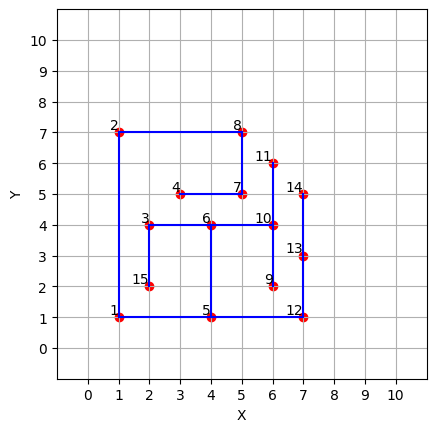

Number of solutions:  1


In [120]:
plot_all_solutions(graph,lines,points,vertices)

No_crossing_lines: [[-7, -13], [-11, -14]]
K is: 14
[[1, 5, 12, 13, 14, 7, 8, 2], [3, 15, 9, 10, 6]]
[[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16]]


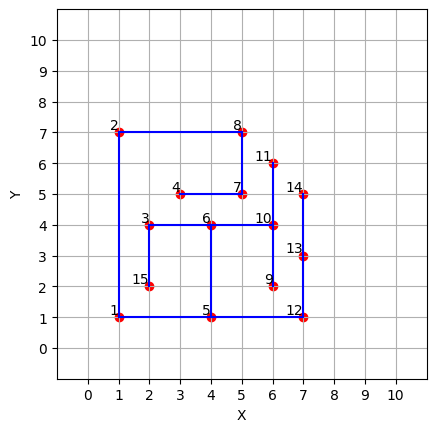

In [121]:
get_minimum_lenght_solution(graph,lines,points,vertices)

**Cycles example**

defaultdict(<class 'list'>, {1: [(4, 1), (5, 1)], 2: [(4, 1), (6, 1)], 3: [(4, 1), (5, 1), (6, 1)]})


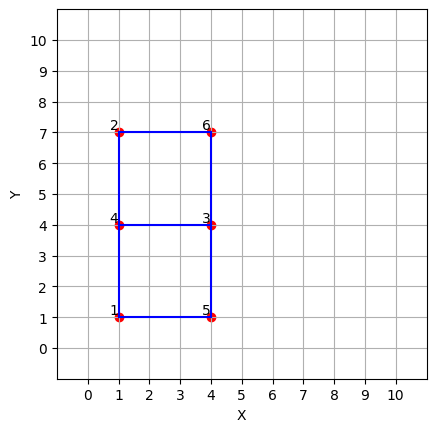

[(1, 4, 1), (1, 5, 1), (2, 4, 1), (2, 6, 1), (3, 4, 1), (3, 5, 1), (3, 6, 1)]
dict_items([(1, ((1,1),(1,4))), (2, ((1,1),(4,1))), (3, ((1,7),(1,4))), (4, ((1,7),(4,7))), (5, ((4,4),(1,4))), (6, ((4,4),(4,1))), (7, ((4,4),(4,7)))])


In [57]:
p1 = Point(1,1)
p2 = Point(1,7)
p5 = Point(4,4)
p6 = Point(1,4)
p8 = Point(4,1)
p9 = Point(4,7)

points = [p1,p2,p5,p6,p8,p9]
graph,vertices,lines = initialize_graph(points)
print(lines.items())

In [58]:
all_cycles(graph)

[[1, 5, 3, 6, 2, 4], [1, 5, 3, 4], [2, 4, 3, 6]]


[[1, 5, 3, 6, 2, 4], [1, 5, 3, 4], [2, 4, 3, 6]]

No_crossing_lines: []
K is: 5
[[1, 5, 3, 6, 2, 4], [1, 5, 3, 4], [2, 4, 3, 6]]
Clauses: [[-2, -6, -7, -4, -3], [-2, -6, -5], [-3, -5, -7], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 5, 6], [1, 5, 7], [1, 6, 7], [2, 3, 4], [2, 3, 5], [2, 3, 6], [2, 3, 7], [2, 4, 5], [2, 4, 6], [2, 4, 7], [2, 5, 6], [2, 5, 7], [2, 6, 7], [3, 4, 5], [3, 4, 6], [3, 4, 7], [3, 5, 6], [3, 5, 7], [3, 6, 7], [4, 5, 6], [4, 5, 7], [4, 6, 7], [5, 6, 7], [-1, -2, -3, -4, -5, -6], [-1, -2, -3, -4, -5, -7], [-1, -2, -3, -4, -6, -7], [-1, -2, -3, -5, -6, -7], [-1, -2, -4, -5, -6, -7], [-1, -3, -4, -5, -6, -7], [-2, -3, -4, -5, -6, -7]]
Model is: [1, 2, 3, 4, 5, -6, -7]
Model_lines: {1: ((1,1),(1,4)), 2: ((1,1),(4,1)), 3: ((1,7),(1,4)), 4: ((1,7),(4,7)), 5: ((4,4),(1,4))}


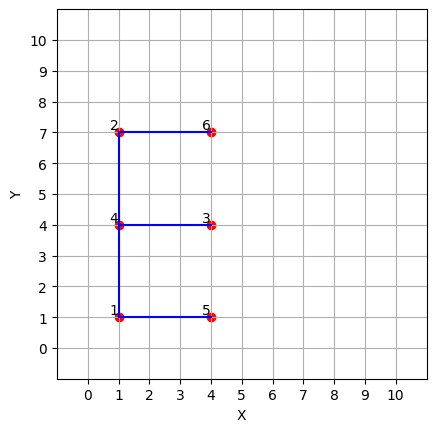

<generator object Minisat22.enum_models at 0x7f98db851850>


In [59]:
find_solution(graph,lines,points,vertices)

No_crossing_lines: []
K is: 5
[[1, 5, 3, 6, 2, 4], [1, 5, 3, 4], [2, 4, 3, 6]]
Clauses: [[-2, -6, -7, -4, -3], [-2, -6, -5], [-3, -5, -7], [1, 2, 3], [1, 2, 4], [1, 2, 5], [1, 2, 6], [1, 2, 7], [1, 3, 4], [1, 3, 5], [1, 3, 6], [1, 3, 7], [1, 4, 5], [1, 4, 6], [1, 4, 7], [1, 5, 6], [1, 5, 7], [1, 6, 7], [2, 3, 4], [2, 3, 5], [2, 3, 6], [2, 3, 7], [2, 4, 5], [2, 4, 6], [2, 4, 7], [2, 5, 6], [2, 5, 7], [2, 6, 7], [3, 4, 5], [3, 4, 6], [3, 4, 7], [3, 5, 6], [3, 5, 7], [3, 6, 7], [4, 5, 6], [4, 5, 7], [4, 6, 7], [5, 6, 7], [-1, -2, -3, -4, -5, -6], [-1, -2, -3, -4, -5, -7], [-1, -2, -3, -4, -6, -7], [-1, -2, -3, -5, -6, -7], [-1, -2, -4, -5, -6, -7], [-1, -3, -4, -5, -6, -7], [-2, -3, -4, -5, -6, -7]]
Model is: [1, 2, 3, 4, 5, -6, -7]
Model_lines: {1: ((1,1),(1,4)), 2: ((1,1),(4,1)), 3: ((1,7),(1,4)), 4: ((1,7),(4,7)), 5: ((4,4),(1,4))}


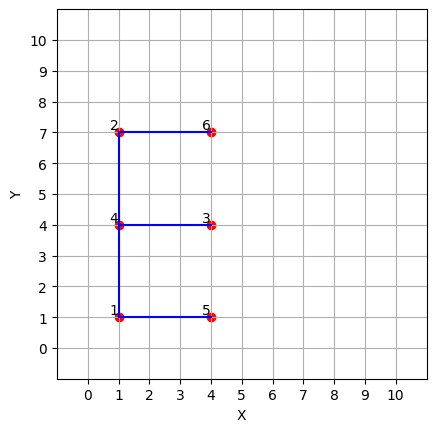

Model is: [1, -2, 3, 4, 5, 6, -7]
Model_lines: {1: ((1,1),(1,4)), 3: ((1,7),(1,4)), 4: ((1,7),(4,7)), 5: ((4,4),(1,4)), 6: ((4,4),(4,1))}


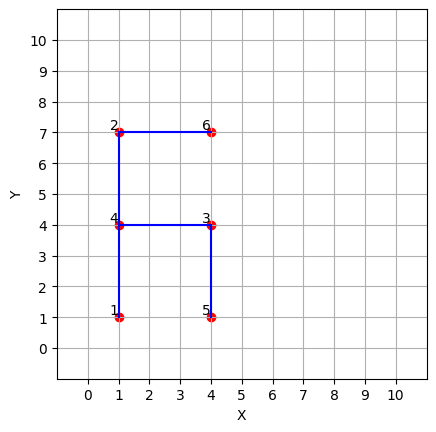

Model is: [1, 2, 3, 4, -5, 6, -7]
Model_lines: {1: ((1,1),(1,4)), 2: ((1,1),(4,1)), 3: ((1,7),(1,4)), 4: ((1,7),(4,7)), 6: ((4,4),(4,1))}


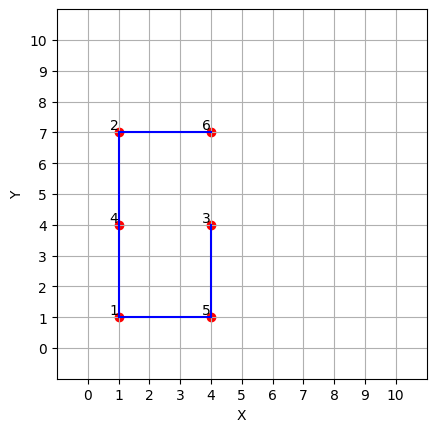

Model is: [1, -2, -3, 4, 5, 6, 7]
Model_lines: {1: ((1,1),(1,4)), 4: ((1,7),(4,7)), 5: ((4,4),(1,4)), 6: ((4,4),(4,1)), 7: ((4,4),(4,7))}


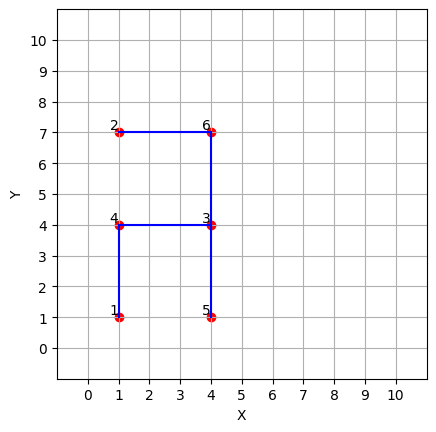

Model is: [1, -2, 3, 4, -5, 6, 7]
Model_lines: {1: ((1,1),(1,4)), 3: ((1,7),(1,4)), 4: ((1,7),(4,7)), 6: ((4,4),(4,1)), 7: ((4,4),(4,7))}


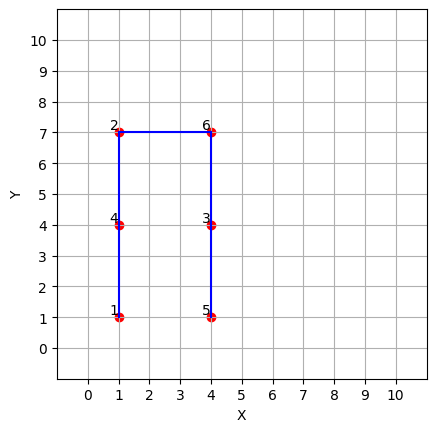

Model is: [1, 2, -3, 4, -5, 6, 7]
Model_lines: {1: ((1,1),(1,4)), 2: ((1,1),(4,1)), 4: ((1,7),(4,7)), 6: ((4,4),(4,1)), 7: ((4,4),(4,7))}


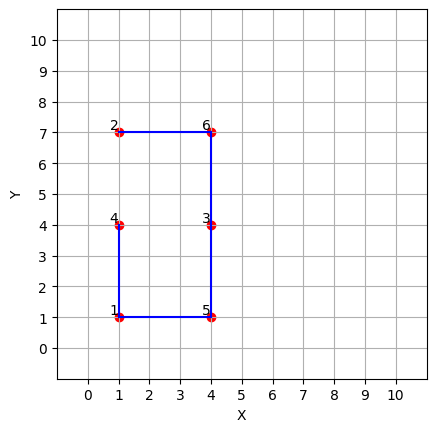

Model is: [1, 2, 3, 4, -5, -6, 7]
Model_lines: {1: ((1,1),(1,4)), 2: ((1,1),(4,1)), 3: ((1,7),(1,4)), 4: ((1,7),(4,7)), 7: ((4,4),(4,7))}


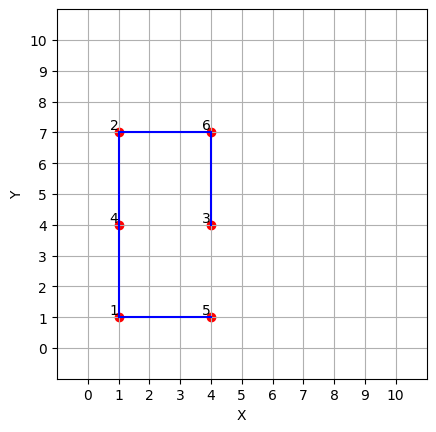

Model is: [1, 2, 3, -4, -5, 6, 7]
Model_lines: {1: ((1,1),(1,4)), 2: ((1,1),(4,1)), 3: ((1,7),(1,4)), 6: ((4,4),(4,1)), 7: ((4,4),(4,7))}


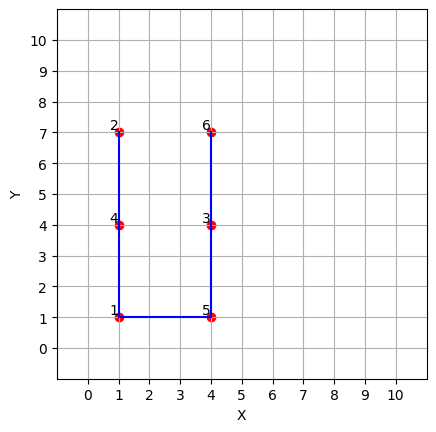

Model is: [1, 2, -3, 4, 5, -6, 7]
Model_lines: {1: ((1,1),(1,4)), 2: ((1,1),(4,1)), 4: ((1,7),(4,7)), 5: ((4,4),(1,4)), 7: ((4,4),(4,7))}


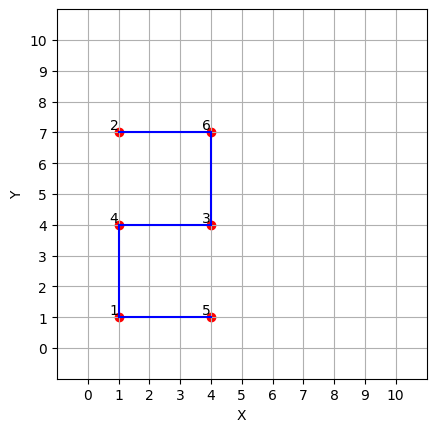

Number of solutions:  9


In [62]:
get_number_solution(graph,lines,points,vertices)

# Broken Example

**Fourth example**



[(0,2), (0,6), (1,0), (1,4), (1,7), (2,6), (3,8), (4,0), (4,2), (4,4), (4,7), (6,1), (5,5), (7,0), (7,2), (7,5), (7,7), (8,1), (8,4), (8,8)]
defaultdict(<class 'list'>, {1: [(2, 1), (9, 1)], 2: [(6, 1)], 3: [(4, 1), (8, 1)], 4: [(5, 1), (10, 1)], 5: [(11, 1)], 7: [(20, 1)], 8: [(9, 1), (14, 1)], 9: [(10, 1), (15, 1)], 10: [(11, 1), (19, 1)], 11: [(17, 1)], 12: [(18, 1)], 13: [(16, 1)], 14: [(15, 1)], 15: [(16, 1)], 16: [(17, 1)], 18: [(19, 1)], 19: [(20, 1)]})


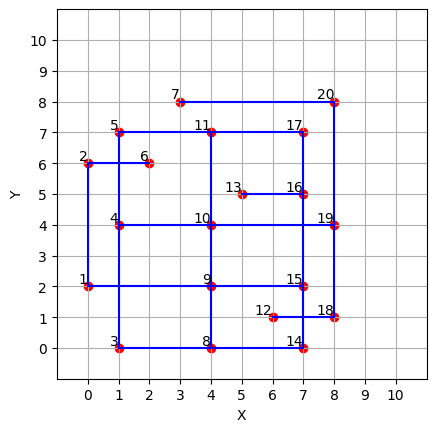

[(1, 2, 1), (1, 9, 1), (2, 6, 1), (3, 4, 1), (3, 8, 1), (4, 5, 1), (4, 10, 1), (5, 11, 1), (7, 20, 1), (8, 9, 1), (8, 14, 1), (9, 10, 1), (9, 15, 1), (10, 11, 1), (10, 19, 1), (11, 17, 1), (12, 18, 1), (13, 16, 1), (14, 15, 1), (15, 16, 1), (16, 17, 1), (18, 19, 1), (19, 20, 1)]


In [49]:
p0 = Point(0,2)
p1=Point(0,6)
p2=Point(1,0)
p3=Point(1,4)
p4=Point(1,7)
p5=Point(2,6)
p6=Point(3,8)
p7=Point(4,0)
p8=Point(4,2)
p9=Point(4,4)
p10=Point(4,7)
p11=Point(5,5)
p12=Point(6,1)
p13=Point(7,0)
p14=Point(7,2)
p15=Point(7,5)
p16=Point(7,7)
p17=Point(8,1)
p18=Point(8,4)
p19=Point(8,8)

points = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p12,p11,p13,p14,p15,p16,p17,p18,p19]
print(points)
graph,vertices,lines = initialize_graph(points)

In [50]:
#plot_graph(points,{})

In [51]:
for i in lines.items():
  print(i)

(1, ((0,2),(0,6)))
(2, ((0,2),(4,2)))
(3, ((0,6),(2,6)))
(4, ((1,0),(1,4)))
(5, ((1,0),(4,0)))
(6, ((1,4),(1,7)))
(7, ((1,4),(4,4)))
(8, ((1,7),(4,7)))
(9, ((3,8),(8,8)))
(10, ((4,0),(4,2)))
(11, ((4,0),(7,0)))
(12, ((4,2),(4,4)))
(13, ((4,2),(7,2)))
(14, ((4,4),(4,7)))
(15, ((4,4),(8,4)))
(16, ((4,7),(7,7)))
(17, ((6,1),(8,1)))
(18, ((5,5),(7,5)))
(19, ((7,0),(7,2)))
(20, ((7,2),(7,5)))
(21, ((7,5),(7,7)))
(22, ((8,1),(8,4)))
(23, ((8,4),(8,8)))


In [52]:
all_cycles(graph)

[[3, 8, 9, 10, 11, 5, 4], [3, 8, 9, 15, 16, 17, 11, 5, 4], [3, 8, 9, 10, 4], [3, 8, 9, 15, 16, 17, 11, 10, 4], [8, 9, 15, 14], [4, 5, 11, 17, 16, 15, 14, 8, 9, 10], [8, 9, 10, 11, 17, 16, 15, 14], [3, 4, 10, 9, 15, 14, 8], [4, 10, 9, 15, 16, 17, 11, 5], [3, 4, 5, 11, 10, 9, 15, 14, 8], [9, 15, 16, 17, 11, 10], [3, 8, 14, 15, 16, 17, 11, 5, 4], [3, 8, 14, 15, 16, 17, 11, 10, 4], [4, 10, 11, 5]]


[[3, 8, 9, 10, 11, 5, 4],
 [3, 8, 9, 15, 16, 17, 11, 5, 4],
 [3, 8, 9, 10, 4],
 [3, 8, 9, 15, 16, 17, 11, 10, 4],
 [8, 9, 15, 14],
 [4, 5, 11, 17, 16, 15, 14, 8, 9, 10],
 [8, 9, 10, 11, 17, 16, 15, 14],
 [3, 4, 10, 9, 15, 14, 8],
 [4, 10, 9, 15, 16, 17, 11, 5],
 [3, 4, 5, 11, 10, 9, 15, 14, 8],
 [9, 15, 16, 17, 11, 10],
 [3, 8, 14, 15, 16, 17, 11, 5, 4],
 [3, 8, 14, 15, 16, 17, 11, 10, 4],
 [4, 10, 11, 5]]

In [53]:
find_solution(graph,lines,points,vertices)

No_crossing_lines: [[-2, -4], [-3, -6], [-15, -20], [-17, -19]]
K is: 19
[[3, 8, 9, 10, 11, 5, 4], [3, 8, 9, 15, 16, 17, 11, 5, 4], [3, 8, 9, 10, 4], [3, 8, 9, 15, 16, 17, 11, 10, 4], [8, 9, 15, 14], [4, 5, 11, 17, 16, 15, 14, 8, 9, 10], [8, 9, 10, 11, 17, 16, 15, 14], [3, 4, 10, 9, 15, 14, 8], [4, 10, 9, 15, 16, 17, 11, 5], [3, 4, 5, 11, 10, 9, 15, 14, 8], [9, 15, 16, 17, 11, 10], [3, 8, 14, 15, 16, 17, 11, 5, 4], [3, 8, 14, 15, 16, 17, 11, 10, 4], [4, 10, 11, 5]]
Clauses: [[-5, -10, -12, -14, -8, -6], [-5, -10, -13, -20, -21, -16, -8, -6], [-5, -10, -12, -7], [-5, -10, -13, -20, -21, -16, -14, -7], [-10, -13, -19], [-6, -8, -16, -21, -20, -19, -11, -10, -12], [-10, -12, -14, -16, -21, -20, -19], [-4, -7, -12, -13, -19, -11], [-7, -12, -13, -20, -21, -16, -8], [-4, -6, -8, -14, -12, -13, -19, -11], [-13, -20, -21, -16, -14], [-5, -11, -19, -20, -21, -16, -8, -6], [-5, -11, -19, -20, -21, -16, -14, -7], [-7, -14, -8], [-2, -4], [-3, -6], [-15, -20], [-17, -19], [1, 2, 3, 4, 5], [1, 2, 

[(1,3), (1,7), (2,1), (2,5), (2,8), (3,7), (4,9), (5,1), (5,3), (5,5), (5,8), (7,2), (6,6), (8,1), (8,3), (8,6), (8,8), (9,2), (9,5), (9,9)]
defaultdict(<class 'list'>, {1: [(2, 1), (9, 1)], 2: [(6, 1)], 3: [(4, 1), (8, 1)], 4: [(5, 1), (10, 1)], 5: [(11, 1)], 7: [(20, 1)], 8: [(9, 1), (14, 1)], 9: [(10, 1), (15, 1)], 10: [(11, 1), (19, 1)], 11: [(17, 1)], 12: [(18, 1)], 13: [(16, 1)], 14: [(15, 1)], 15: [(16, 1)], 16: [(17, 1)], 18: [(19, 1)], 19: [(20, 1)]})


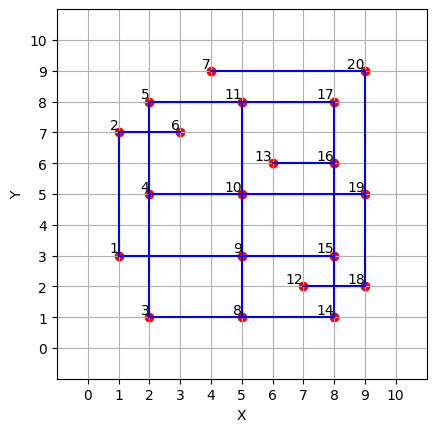

[(1, 2, 1), (1, 9, 1), (2, 6, 1), (3, 4, 1), (3, 8, 1), (4, 5, 1), (4, 10, 1), (5, 11, 1), (7, 20, 1), (8, 9, 1), (8, 14, 1), (9, 10, 1), (9, 15, 1), (10, 11, 1), (10, 19, 1), (11, 17, 1), (12, 18, 1), (13, 16, 1), (14, 15, 1), (15, 16, 1), (16, 17, 1), (18, 19, 1), (19, 20, 1)]


In [54]:
p0 = Point(1,3)
p1=Point(1,7)
p2=Point(2,1)
p3=Point(2,5)
p4=Point(2,8)
p5=Point(3,7)
p6=Point(4,9)
p7=Point(5,1)
p8=Point(5,3)
p9=Point(5,5)
p10=Point(5,8)
p11=Point(6,6)
p12=Point(7,2)
p13=Point(8,1)
p14=Point(8,3)
p15=Point(8,6)
p16=Point(8,8)
p17=Point(9,2)
p18=Point(9,5)
p19=Point(9,9)

points = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p12,p11,p13,p14,p15,p16,p17,p18,p19]
print(points)
graph,vertices,lines = initialize_graph(points)

In [55]:
find_solution(graph,lines,points,vertices)

No_crossing_lines: [[-2, -4], [-3, -6], [-15, -20], [-17, -19]]
K is: 19
[[3, 8, 9, 10, 11, 5, 4], [3, 8, 9, 15, 16, 17, 11, 5, 4], [3, 8, 9, 10, 4], [3, 8, 9, 15, 16, 17, 11, 10, 4], [8, 9, 15, 14], [4, 5, 11, 17, 16, 15, 14, 8, 9, 10], [8, 9, 10, 11, 17, 16, 15, 14], [3, 4, 10, 9, 15, 14, 8], [4, 10, 9, 15, 16, 17, 11, 5], [3, 4, 5, 11, 10, 9, 15, 14, 8], [9, 15, 16, 17, 11, 10], [3, 8, 14, 15, 16, 17, 11, 5, 4], [3, 8, 14, 15, 16, 17, 11, 10, 4], [4, 10, 11, 5]]
Clauses: [[-5, -10, -12, -14, -8, -6], [-5, -10, -13, -20, -21, -16, -8, -6], [-5, -10, -12, -7], [-5, -10, -13, -20, -21, -16, -14, -7], [-10, -13, -19], [-6, -8, -16, -21, -20, -19, -11, -10, -12], [-10, -12, -14, -16, -21, -20, -19], [-4, -7, -12, -13, -19, -11], [-7, -12, -13, -20, -21, -16, -8], [-4, -6, -8, -14, -12, -13, -19, -11], [-13, -20, -21, -16, -14], [-5, -11, -19, -20, -21, -16, -8, -6], [-5, -11, -19, -20, -21, -16, -14, -7], [-7, -14, -8], [-2, -4], [-3, -6], [-15, -20], [-17, -19], [1, 2, 3, 4, 5], [1, 2, 